# Prep

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#....*...*..*.*.*..*...*....#

import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
from PIL import Image
#
from sklearn.preprocessing import OneHotEncoder

import time
import os

#....*...*..*.*.*..*...*....#

if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')

print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Mounted at /content/drive
Using PyTorch version: 2.2.1+cu121  Device: cuda


# Open and Process Data

In [3]:
current = '/content/drive/MyDrive/dlmathon'
path = current+'/data_kfood'
train_path = path+'/train'
test_path = path+'/test'

In [4]:
#############################
## ----> Input valset:(T/F)##
#############################
valset = False

train_name_list = os.listdir(train_path)
length = len(train_name_list)
val_path = path+'/val'
# os.mkdir(val_path)

if valset == True:
    frac = round(0.1*length)
    for i in train_name_list[:frac]:
        os.rename(train_path+i,val_path+i)

### Show a sample image

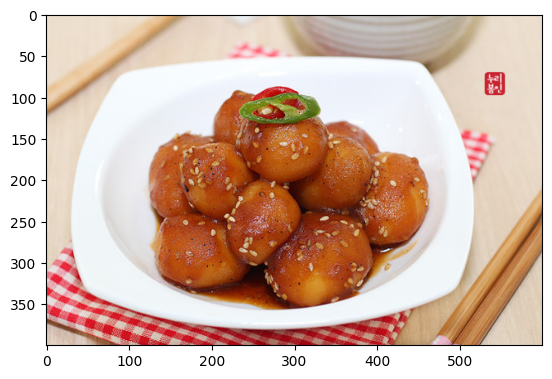

In [5]:
liszt = []
for i in os.listdir(train_path):
    if os.path.isdir(train_path+'/'+i) == True:
        liszt.append(i)
num_classes = len(liszt)
lisztjr = os.listdir(train_path+'/'+liszt[0])
img = Image.open(train_path+'/'+liszt[0]+'/'+lisztjr[0])
plt.imshow(img)

In [6]:
'''
# Debugging Block

# because of some unexplainable issues here I need to rename all the files here
os.listdir(train_path)
train_cls = []
for i in os.listdir(train_path):
    if os.path.isdir(train_path+'/'+i) == True:
        train_cls.append(i)
os.listdir(test_path)
test_cls = []
for i in os.listdir(test_path):
    if os.path.isdir(test_path+'/'+i) == True:
        test_cls.append(i)
'''
'''
for cls in train_cls:
    dpath = train_path+'/'+cls
    for fname in os.listdir(dpath):
        fpath = dpath+'/'+fname
        if fname[0:2] == '._':
            split = fpath.split('.')
            if len(split) == 3:
                os.rename(fpath,split[0]+split[1]+'.'+split[2][1:])
            else:
                print('Girl check the file name, you miscalculated something')

for cls in test_cls:
    dpath = test_path+'/'+cls
    for fname in os.listdir(dpath):
        fpath = dpath+'/'+fname
        if fname[0:2] == '._':
            split = fpath.split('.')
            if len(split) == 3:
                os.rename(fpath,split[0]+split[1]+'.'+split[2][1:])
            else:
                print('Girl check the file name, you miscalculated something')
'''
'''

for cls in train_cls:
    dpath = train_path+'/'+cls
    for fname in os.listdir(dpath):
        fpath = dpath+'/'+fname
        if fname[0] == '_':
            fname = fname[1:]
            os.rename(fpath,dpath+'/'+fname)

for cls in test_cls:
    dpath = test_path+'/'+cls
    for fname in os.listdir(dpath):
        fpath = dpath+'/'+fname
        if fname[0] == '_':
            fname = fname[1:]
            os.rename(fpath,dpath+'/'+fname)
'''

"\n\nfor cls in train_cls:\n    dpath = train_path+'/'+cls\n    for fname in os.listdir(dpath):\n        fpath = dpath+'/'+fname\n        if fname[0] == '_':\n            fname = fname[1:]\n            os.rename(fpath,dpath+'/'+fname)\n\nfor cls in test_cls:\n    dpath = test_path+'/'+cls\n    for fname in os.listdir(dpath):\n        fpath = dpath+'/'+fname\n        if fname[0] == '_':\n            fname = fname[1:]\n            os.rename(fpath,dpath+'/'+fname)\n"

https://www.projectpro.io/recipes/convert-image-tensor-pytorch


In [7]:
def preprocess(train_path,BATCH_SIZE):

    transform_train = transforms.Compose([
        transforms.Resize(size=(256, 256)),
        transforms.ToTensor()
        ])

    # Load dataset
    train_dataset = datasets.ImageFolder(root=train_path, transform=transform_train)

    # Create DataLoader
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    return(train_dataset,train_loader)

# Prepare to Train.
## Set hyperparameters and stuff

In [8]:
###############################################
## -----> Input Training Hyperparameters:    ##
###############################################

BATCH_SIZE = 30
EPOCHS = 10
loss = nn.CrossEntropyLoss()
learning_rate = 0.001

In [9]:
train_dataset,train_loader = preprocess(train_path,BATCH_SIZE)

# Rudimentary CNN Model: ScheisseCNN

In [10]:
class ScheisseCNN(nn.Module): # you always have to write (nn.Module) for it to work
    def __init__(self):
        super(ScheisseCNN,self).__init__()
        dim = np.array([256,256])
        KERNEL1 = 3
        self.conv1 = nn.Conv2d(3,16,kernel_size=KERNEL1,stride=1,padding=0)
        dim = dim - np.array([KERNEL1-1,KERNEL1-1])
        #maxpool
        dim = dim/2
        KERNEL2 = 3
        OUT = 32
        self.conv2 = nn.Conv2d(16,OUT,kernel_size=KERNEL2,stride=1,padding=0)
        dim = dim - np.array([KERNEL1-1,KERNEL1-2])
        #self.fc1 = nn.Linear(OUT*dim[0]*dim[1], 128) #FC layer flattens the entire CNN output
        self.fc1 = nn.Linear(500000, 128) #FC layer flattens the entire CNN output
        self.outlayer = nn.Linear(128,num_classes)

        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1,
        # padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

    def forward(self,x):
        x = self.conv1(x)
        print('after conv1: '+str(x.shape))
        x = nn.functional.relu(x)
        x = nn.functional.max_pool2d(x,2)
        print('after maxpool: '+str(x.shape))
        x = self.conv2(x)
        print('after conv2: '+str(x.shape))
        x = nn.functional.relu(x)
        x = torch.flatten(x,1)
        print('after flatten: '+str(x.shape))
        x = self.fc1(x)
        print('after fc1: '+str(x.shape))
        x = self.outlayer(x)
        print('output: '+str(x.shape))
        x = nn.functional.softmax(x)
        return x

        #FC layer flattens the entire CNN output

In [11]:

model = ScheisseCNN()
model.cuda()
loss = loss
learning_rate = learning_rate
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

print(model)

ScheisseCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500000, out_features=128, bias=True)
  (outlayer): Linear(in_features=128, out_features=5, bias=True)
)


In [12]:
print(model)
# randomly initialized parameters
'''
for param in model.named_parameters(): # or just parameters, but in this case all params are named
    print(param[0])
    print(param)
'''

ScheisseCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=500000, out_features=128, bias=True)
  (outlayer): Linear(in_features=128, out_features=5, bias=True)
)


'\nfor param in model.named_parameters(): # or just parameters, but in this case all params are named\n    print(param[0])\n    print(param)\n'

Cf. for study purposes. Having

        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=1,padding=0)
        self.conv2 = nn.Conv2d(16,32,kernel_size=3,stride=1,padding=0)
        self.fc1 = nn.Linear(252, 128) #FC layer flattens the entire CNN output
        self.outlayer = nn.Linear(128,num_classes)

and

        x = self.conv1(x)
        x = nn.functional.relu(x)
        # x = nn.functional.max_pool2d(x,2)
        x = self.conv2(x)
        x = nn.functional.relu(x)
        x = self.fc1(x)
        x = self.outlayer(x)
        x = nn.functional.softmax(x)
        return x

leads to the error:

only batches of spatial targets supported (3D tensors) but got targets of dimension: [30]

and when asked to print these:

    label shape
    torch.Size([30])
    output shape
    torch.Size([30, 32, 252, 5])
    label
    tensor([1., 2., 1., 1., 4., 3., 0., 3., 4., 3., 0., 0., 3., 0., 2., 4., 3., 3.,
        0., 0., 3., 3., 0., 0., 2., 4., 4., 1., 3., 3.], device='cuda:0')
    output
    tensor([[[[0.0311, 0.0312, 0.0312, 0.0310, 0.0311],
          [0.0310, 0.0313, 0.0313, 0.0310, 0.0311],
          [0.0308, 0.0314, 0.0313, 0.0310, 0.0312],
          ...,

which means first of all that the label comes as one tensor per minibatch (we had batch size 30).

We have to first
1. Somehow get rid of the 32, 252 part: (I have no idea why this even exists in the output - do each nodes take whole tensors instead of values? This is unheard of and probably never happens to anyone else!) because that's completely unnecessary and irrelevant.
2. The 5 part in the output IS meaningful, what's the problem is that the label doesn't have it. We need to turn the label to a one-hot code format.

So:
label to [30,5]
and output to [30,5].

1. Flatten: https://csm-kr.tistory.com/66



In [18]:
#TRY

model.train()

for index, (image,label) in enumerate(train_loader):
    image = image.to(DEVICE, dtype=torch.float)
    label = label.to(DEVICE, dtype=torch.float)

    one_hot_labels = torch.nn.functional.one_hot(label.to(torch.int64), num_classes=num_classes)
    ohf_label = one_hot_labels.to(torch.float32)

    optimizer.zero_grad() #initialize optimizer
    output = model(image)
    # debugging block
    print('label shape')
    print(ohf_label.shape)
    print('output shape')
    print(output.shape)
    print('label')
    print(ohf_label)
    print('output')
    print(output)
    loss = loss(output,ohf_label)
    loss.backward()
    optimizer.step()
    # this in itself updates the parameters!!




after conv1: torch.Size([30, 16, 254, 254])
after maxpool: torch.Size([30, 16, 127, 127])
after conv2: torch.Size([30, 32, 125, 125])
after flatten: torch.Size([30, 500000])
after fc1: torch.Size([30, 128])
output: torch.Size([30, 5])
label shape
torch.Size([30, 5])
output shape
torch.Size([30, 5])
label
tensor([[0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
    

<ipython-input-10-7794b66d8254>:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


TypeError: 'Tensor' object is not callable

# Begin Training

In [ ]:
def train(model,train_loader,optimizer,batch_size):
    model.train()

    losslist = []
    batch_loss_list = []
    correct = []
    batch_acc_list = []

    count = 0

    for index, (image,label) in enumerate(train_loader):
        image = image.to(DEVICE, dtype=torch.float)
        label = label.to(DEVICE)
        optimizer.zero_grad() #initialize optimizer
        output = model(image)
        loss = loss(output,label)
        loss.backward()
        optimizer.step()
        # this in itself updates the parameters!!
        print('output')
        print(output)

        losslist.append(loss.item)
        prediction = output.max(1, keepdim = True)[1]
        count = count+1

        if output == label:
            correct.append(index)

        if index % batch_size == 0:
            batchnum = index/batch_size
            trainloss = sum(losslist)/len(losslist)
            batch_loss_list.append(trainloss)
            trainaccuracy = len(correct)/len(losslist)
            batch_acc_list.append(trainaccuracy)
            losslist = []
            correct = []

    return batch_loss_list, batch_acc_list, count

In [ ]:
def test(model,test_loader):
    model.eval()

    testloss = 0
    correct = 0
    wrong = []





In [ ]:
def givetime(start_time,end_time):
    duration_seconds = end_time-start_time
    # Convert seconds to hours, minutes, and seconds
    hours, remainder = divmod(duration_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    # Print the duration in a human-readable format
    print(f"Epoch training duration: {int(hours)} hours, {int(minutes)} minutes, and {int(seconds)} seconds.")
    return duration_seconds

In [ ]:
# miscellany
timelist = []

total_loss = []
total_acc = []

# train and test loop
for epoch in range(EPOCHS):
    start_time = time.time()

    t = train(model,train_loader,optimizer,BATCH_SIZE)
    # this still calls the function, so the weight updates still happen.

    epochnum = epoch+1

    end_time = time.time()
    g = givetime(start_time,end_time)
    timelist.append(g)

    total_loss[epoch] = t[0]
    total_acc[epoch] = t[1]









torch.Size([30, 16, 254, 254])
torch.Size([30, 16, 254, 254])
torch.Size([30, 32, 252, 252])
torch.Size([30, 32, 252, 252])
torch.Size([30, 32, 252, 128])
torch.Size([30, 32, 252, 5])
torch.Size([30, 32, 252, 5])


<ipython-input-10-107f93a933e0>:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = nn.functional.softmax(x)


NameError: name 'criterion' is not defined

# Plot Training Results

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10))

for i in range(EPOCHS):
    numbatch = math.floor(t[2]/BATCH_SIZE)
    x = np.linspace(i*t[2],(i+1)*t[2],numbatch+1)[:numbatch+1]
    axs[0, 0].plot(x, total_loss[i],label='Epoch '+str(i))
    axs[0, 1].plot(x, total_acc[i],label='Epoch '+str(i))

    # #E3B24F, #81C9E5

axs[0, 0].set_title('Training Loss')
axs[0, 1].set_title('Training Accuracy)')

plt.suptitle('Training Loss/Accuracy at each Minibatch', fontsize=16)

for ax in axs.flat:
    ax.grid(True)

plt.tight_layout()
plt.show()

# Show correctly predicted images / outliers
If needed....

In [ ]:
def show_imgs(imgs, labels, preds=None):
    f, axes= plt.subplots(1, 8, figsize=(30,5))
    for i, axis in enumerate(axes):
        axes[i].imshow(np.squeeze(np.transpose(imgs[i].numpy(), (1, 2, 0))), cmap='gray')
        axes[i].set_title(f'Label: {labels[i].numpy()}')
        if preds != None:
            axes[i].set_xlabel(f'Pred: {np.argmax(preds[i].numpy())}')
    plt.show()

show_imgs(images, labels)

## shows the sample train_data
## 30 degree rotation!